# Importing Dataset and unzipping

In [1]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip # This is our dataset link. I will include this command in the description

--2023-05-11 06:54:03--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2023-05-11 06:54:04--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  14.5MB/s    in 4m 2s   

2023-05-11 06:58:06 (13.9 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_

# **Library import**

In [2]:
# Do set your runtime to GPU. You will need it
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable

In [3]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [4]:
from torch.utils.data import DataLoader, Dataset

In [5]:
from PIL import Image

In [6]:
from os.path import join

# **PreProcessing**

In [7]:
torch.autograd.set_detect_anomaly(True)

In [8]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [9]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [10]:

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

# **Load Data**

In [12]:
train_set = TrainDatasetFromFolder("DIV2K_train_HR", crop_size=CROP_SIZE,
                                   upscale_factor=UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Model Implementation**

In [13]:
from torch import nn, optim

In [14]:

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual
  

In [15]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, 
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

# **Generator**

In [16]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

# **Discriminator**

In [17]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

# **VGG 16**

In [18]:
from torchvision.models.vgg import vgg16

# **Losses**

In [19]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size
  
  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [20]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg16(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [21]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cuda')

In [22]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [23]:
generator_criterion = GeneratorLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]


In [24]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [25]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

# **Train The Model**

In [26]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

In [27]:

from tqdm import tqdm
import os

In [47]:
N_EPOCHS = 50 

[1/50] Loss_D: 0.0588 Loss_G: 0.0078 D(x): 0.9637 D(G(z)): 0.9637: 100%|██████████| 13/13 [01:01<00:00,  4.70s/it]
[2/50] Loss_D: 0.0768 Loss_G: 0.0078 D(x): 0.9556 D(G(z)): 0.9556: 100%|██████████| 13/13 [01:00<00:00,  4.66s/it]
[3/50] Loss_D: 0.1533 Loss_G: 0.0080 D(x): 0.9159 D(G(z)): 0.9159: 100%|██████████| 13/13 [01:01<00:00,  4.73s/it]
[4/50] Loss_D: 0.0380 Loss_G: 0.0077 D(x): 0.9778 D(G(z)): 0.9778: 100%|██████████| 13/13 [01:00<00:00,  4.68s/it]
[5/50] Loss_D: 0.0224 Loss_G: 0.0085 D(x): 0.9866 D(G(z)): 0.9866: 100%|██████████| 13/13 [01:01<00:00,  4.70s/it]
[6/50] Loss_D: 0.0247 Loss_G: 0.0081 D(x): 0.9898 D(G(z)): 0.9898: 100%|██████████| 13/13 [01:01<00:00,  4.74s/it]
[7/50] Loss_D: 0.0141 Loss_G: 0.0087 D(x): 0.9904 D(G(z)): 0.9904: 100%|██████████| 13/13 [01:00<00:00,  4.64s/it]
[8/50] Loss_D: 0.0198 Loss_G: 0.0076 D(x): 0.9866 D(G(z)): 0.9866: 100%|██████████| 13/13 [01:01<00:00,  4.73s/it]
[9/50] Loss_D: 0.0167 Loss_G: 0.0074 D(x): 0.9895 D(G(z)): 0.9895: 100%|████████

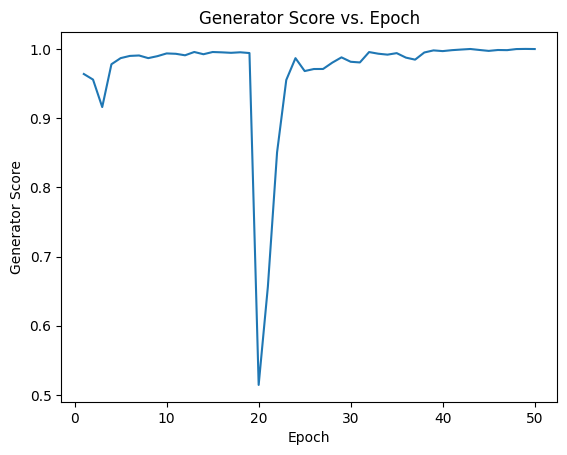

In [48]:
import matplotlib.pyplot as plt

# Create empty list to store generator scores for each epoch
generator_scores = []

for epoch in range(1, N_EPOCHS + 1):
    train_bar = tqdm(trainloader)
    running_results = {'batch_sizes':0, 'd_loss':0,
                       "g_loss":0, "d_score":0, "g_score":0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        real_img = Variable(target)
        real_img = real_img.to(device)
        z = Variable(data)
        z = z.to(device)

        ## Update Discriminator ##
        fake_img = netG(z)
        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph = True)
        optimizerD.step()

        ## Now update Generator
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        netG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()

        fake_img = netG(z)
        fake_out = netD(fake_img).mean()

        optimizerG.step()

        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += real_out.item() * batch_size

        ## Updating the progress bar
        train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
            epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']
        ))
    # Append generator score to list for current epoch
    generator_scores.append(running_results['g_score'] / running_results['batch_sizes'])

# Plot line graph of generator scores vs. epoch number
plt.plot(range(1, N_EPOCHS+1), generator_scores)
plt.xlabel('Epoch')
plt.ylabel('Generator Score')
plt.title('Generator Score vs. Epoch')
plt.show()


In [55]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Create trace
trace = go.Scatter(
    x = list(range(1, N_EPOCHS+1)),
    y = generator_scores,
    mode = 'lines+markers'
)

# Create layout
layout = go.Layout(
    title = 'Generator Score vs. Epoch',
    xaxis = dict(title = 'Epoch'),
    yaxis = dict(title = 'Generator Score')
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Display the plot
pyo.iplot(fig)


In [57]:
import plotly.graph_objs as go

# Define the data
data = [go.Bar(
            x=list(range(1, N_EPOCHS+1)),
            y=generator_scores,
            marker=dict(
                color=list(range(1, N_EPOCHS+1)),
                colorscale='Viridis',
                showscale=True
            )
    )]

# Define the layout
layout = go.Layout(
    title='Generator Score vs. Epoch',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Generator Score'),
)

# Create the figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show()


In [56]:
import plotly.graph_objs as go

# Define data trace
trace = go.Scatter(
    x=list(range(1, N_EPOCHS+1)),
    y=generator_scores,
    mode='markers',
    marker=dict(
        size=10,
        color=list(range(1, N_EPOCHS+1)),
        colorscale='Viridis',
        showscale=True
    )
)

# Define layout
layout = go.Layout(
    title='Generator Score vs. Epoch',
    xaxis=dict(
        title='Epoch'
    ),
    yaxis=dict(
        title='Generator Score'
    )
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show figure
fig.show()


## **Saving The Model**

In [49]:
# Save the generator model
torch.save(netG.state_dict(), 'generator_50.pth')


## **Testing Model On Costume Data**

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


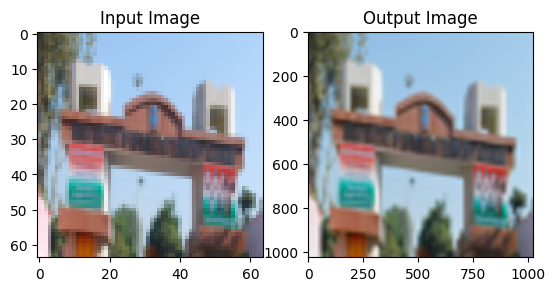

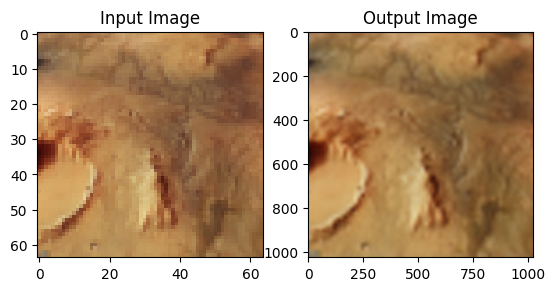

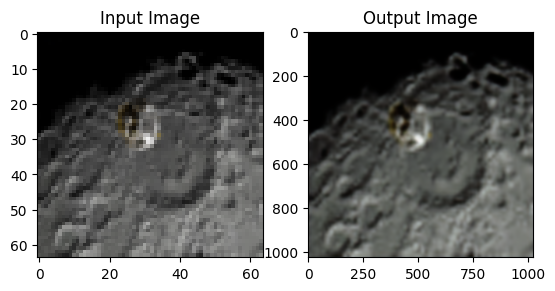

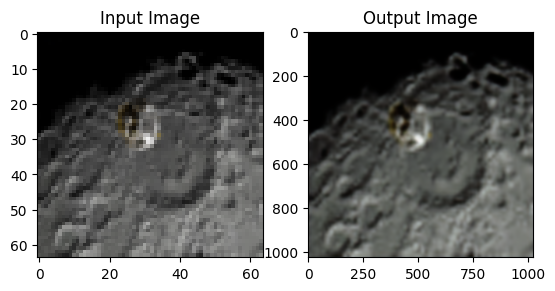

In [50]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the generator model
generator = Generator(scale_factor=4)
generator.load_state_dict(torch.load('/content/generator_50.pth'))
generator.eval()

# Define the input image path
input_path = '/content/1.jfif'

# Define the output image path
# output_path = 'output_image.jpg'

# Define the scale factor for the model
scale_factor = 4

# Define the transimport torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the generator model
generator = Generator(scale_factor=4)
generator.load_state_dict(torch.load('/content/generator_50.pth'))
generator.eval()

# Define the input image path
input_path = '/content/IIITA.png'

# Define the output image path
# output_path = 'output_image.jpg'

# Define the scale factor for the model
scale_factor = 4

# Define the transform to resize the input image to the required size
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the input image and resize it
input_image = Image.open(input_path)
input_image = transform(input_image)

# Upscale the input image using bicubic interpolation
upscale_transform = transforms.Resize((64*scale_factor, 64*scale_factor), interpolation=Image.BICUBIC)
upscaled_input_image = upscale_transform(input_image)

# Generate the high-resolution image using the generator model
with torch.no_grad():
    output_image = generator(upscaled_input_image.unsqueeze(0)).squeeze()

# Convert the output tensor to a PIL image and show input/output images
output_image = transforms.ToPILImage()(output_image.clamp(0, 1))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(input_image.permute(1, 2, 0))
axs[0].set_title('Input Image')
axs[1].imshow(output_image)

axs[1].set_title('Output Image')
plt.show()
# Define the input image path
input_path = '/content/mars.jpg'

# Define the output image path
# output_path = 'output_image.jpg'

# Define the scale factor for the model
scale_factor = 4

# Define the transform to resize the input image to the required size
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the input image and resize it
input_image = Image.open(input_path)
input_image = transform(input_image)

# Upscale the input image using bicubic interpolation
upscale_transform = transforms.Resize((64*scale_factor, 64*scale_factor), interpolation=Image.BICUBIC)
upscaled_input_image = upscale_transform(input_image)

# Generate the high-resolution image using the generator model
with torch.no_grad():
    output_image = generator(upscaled_input_image.unsqueeze(0)).squeeze()

# Convert the output tensor to a PIL image and show input/output images
output_image = transforms.ToPILImage()(output_image.clamp(0, 1))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(input_image.permute(1, 2, 0))
axs[0].set_title('Input Image')
axs[1].imshow(output_image)

axs[1].set_title('Output Image')
plt.show()
# Define the input image path
input_path = '/content/moon.webp'

# Define the output image path
# output_path = 'output_image.jpg'

# Define the scale factor for the model
scale_factor = 4

# Define the transform to resize the input image to the required size
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the input image and resize it
input_image = Image.open(input_path)
input_image = transform(input_image)

# Upscale the input image using bicubic interpolation
upscale_transform = transforms.Resize((64*scale_factor, 64*scale_factor), interpolation=Image.BICUBIC)
upscaled_input_image = upscale_transform(input_image)

# Generate the high-resolution image using the generator model
with torch.no_grad():
    output_image = generator(upscaled_input_image.unsqueeze(0)).squeeze()

# Convert the output tensor to a PIL image and show input/output images
output_image = transforms.ToPILImage()(output_image.clamp(0, 1))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(input_image.permute(1, 2, 0))
axs[0].set_title('Input Image')
axs[1].imshow(output_image)

axs[1].set_title('Output Image')
plt.show()
# form to resize the input image to the required size
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the input image and resize it
input_image = Image.open(input_path)
input_image = transform(input_image)

# Upscale the input image using bicubic interpolation
upscale_transform = transforms.Resize((64*scale_factor, 64*scale_factor), interpolation=Image.BICUBIC)
upscaled_input_image = upscale_transform(input_image)

# Generate the high-resolution image using the generator model
with torch.no_grad():
    output_image = generator(upscaled_input_image.unsqueeze(0)).squeeze()

# Convert the output tensor to a PIL image and show input/output images
output_image = transforms.ToPILImage()(output_image.clamp(0, 1))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(input_image.permute(1, 2, 0))
axs[0].set_title('Input Image')
axs[1].imshow(output_image)

axs[1].set_title('Output Image')
plt.show()


In [ ]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training
